<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Gemini_Human_Feedback_Disagreement_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini_Human_Feedback_Disagreement_Framework

This notebook explores how LLM-powered systems should behave when **human feedback disagrees** and no single, objective ground truth exists.

In real-world product and platform environments, feedback signals are often:
- Subjective
- Emotionally biased
- Inconsistent across users
- Conflicting in sentiment, urgency, or interpretation

Rather than asking:
“What is the correct answer?”

This notebook asks:
“How should a system respond when humans themselves disagree?”

The focus is on **decision reliability under disagreement**, not sentiment classification accuracy.

Core system goals:
- Detect disagreement and uncertainty in user feedback
- Avoid false confidence when sentiment is polarized
- Decide when to proceed, defer, abstain, or escalate
- Signal uncertainty clearly to downstream product teams
- Treat human-in-the-loop escalation as a first-class outcome

This notebook emphasizes:
- Engineering judgment under ambiguity
- Responsible automation in subjective domains
- Clear separation between signal disagreement and decision risk

The domain context is **human feedback and product signals**, including:
- App reviews
- Support tickets
- Survey responses
- Internal stakeholder notes

The notebook will demonstrate how disagreement-aware systems can:
- Operate safely without consensus
- Avoid over-optimizing for loud or extreme voices
- Provide structured guidance instead of forced decisions

## Step 1 — Input Modeling: Conflicting Human Feedback

The system begins by ingesting **multiple human feedback signals** related to the same product feature or decision.

These inputs may:
- Express different sentiments (positive, negative, neutral)
- Disagree on severity or urgency
- Reflect subjective or emotional perspectives
- Come from sources with varying credibility

At this stage, the system does **not** attempt to resolve disagreement.
Its sole objective is to **capture and preserve signal diversity** for downstream analysis.

### What This Step Does

- Ingests multiple, potentially conflicting human feedback signals
- Preserves disagreement without forcing early resolution
- Stores sentiment, confidence, and source metadata explicitly
- Establishes a structured input layer for later interpretation and scoring

This ensures the system starts from **realistic, messy human inputs**, exactly as they appear in production environments.

In [1]:
# Sample human feedback inputs about the same product feature
human_feedback = [
    {
        "source": "App Review",
        "user_type": "End User",
        "sentiment": "Negative",
        "confidence": 0.9,
        "text": "The new update completely broke my workflow. This needs to be fixed immediately."
    },
    {
        "source": "Support Ticket",
        "user_type": "Power User",
        "sentiment": "Neutral",
        "confidence": 0.6,
        "text": "Some issues with the update, but nothing critical so far."
    },
    {
        "source": "Survey Response",
        "user_type": "Casual User",
        "sentiment": "Positive",
        "confidence": 0.8,
        "text": "I actually like the new changes. It feels smoother to me."
    },
    {
        "source": "Internal PM Note",
        "user_type": "Stakeholder",
        "sentiment": "Concerned",
        "confidence": 0.7,
        "text": "Mixed external feedback. Risk of backlash if issues are not addressed quickly."
    }
]

human_feedback

[{'source': 'App Review',
  'user_type': 'End User',
  'sentiment': 'Negative',
  'confidence': 0.9,
  'text': 'The new update completely broke my workflow. This needs to be fixed immediately.'},
 {'source': 'Support Ticket',
  'user_type': 'Power User',
  'sentiment': 'Neutral',
  'confidence': 0.6,
  'text': 'Some issues with the update, but nothing critical so far.'},
 {'source': 'Survey Response',
  'user_type': 'Casual User',
  'sentiment': 'Positive',
  'confidence': 0.8,
  'text': 'I actually like the new changes. It feels smoother to me.'},
 {'source': 'Internal PM Note',
  'user_type': 'Stakeholder',
  'sentiment': 'Concerned',
  'confidence': 0.7,
  'text': 'Mixed external feedback. Risk of backlash if issues are not addressed quickly.'}]

## Step 2 — LLM Interpretation of Individual Feedback Signals

Each human feedback signal is analyzed **independently** by the LLM.

The system does not attempt to reconcile disagreement at this stage.
Instead, it extracts structured interpretations from each signal in isolation.

The analysis focuses on:
- Interpreted sentiment strength
- Perceived urgency
- Inferred product impact
- Model confidence in the interpretation

### What This Step Does

- Applies independent LLM interpretation to each feedback signal
- Translates qualitative sentiment into a structured numeric score
- Infers urgency without aggregating or resolving disagreement
- Preserves per-signal confidence and contextual metadata

This creates a clean analytical layer that enables **disagreement detection without premature consensus**.

In [2]:
# Simulated LLM interpretation for each feedback item
def interpret_feedback(feedback):
    sentiment_map = {
        "Negative": (-0.8, "High"),
        "Concerned": (-0.4, "Medium"),
        "Neutral": (0.0, "Low"),
        "Positive": (0.6, "Low")
    }

    sentiment_score, urgency = sentiment_map.get(
        feedback["sentiment"], (0.0, "Low")
    )

    return {
        "source": feedback["source"],
        "user_type": feedback["user_type"],
        "original_text": feedback["text"],
        "interpreted_sentiment_score": sentiment_score,
        "interpreted_urgency": urgency,
        "model_confidence": feedback["confidence"]
    }

# Apply interpretation to all feedback
llm_feedback_analysis = [
    interpret_feedback(fb) for fb in human_feedback
]

llm_feedback_analysis

[{'source': 'App Review',
  'user_type': 'End User',
  'original_text': 'The new update completely broke my workflow. This needs to be fixed immediately.',
  'interpreted_sentiment_score': -0.8,
  'interpreted_urgency': 'High',
  'model_confidence': 0.9},
 {'source': 'Support Ticket',
  'user_type': 'Power User',
  'original_text': 'Some issues with the update, but nothing critical so far.',
  'interpreted_sentiment_score': 0.0,
  'interpreted_urgency': 'Low',
  'model_confidence': 0.6},
 {'source': 'Survey Response',
  'user_type': 'Casual User',
  'original_text': 'I actually like the new changes. It feels smoother to me.',
  'interpreted_sentiment_score': 0.6,
  'interpreted_urgency': 'Low',
  'model_confidence': 0.8},
 {'source': 'Internal PM Note',
  'user_type': 'Stakeholder',
  'original_text': 'Mixed external feedback. Risk of backlash if issues are not addressed quickly.',
  'interpreted_sentiment_score': -0.4,
  'interpreted_urgency': 'Medium',
  'model_confidence': 0.7}]

## Step 3 — Disagreement & Variance Scoring Across Human Feedback

With individual feedback signals interpreted, the system now evaluates **how much humans disagree**.

The objective is not to determine who is correct, but to quantify:
- Sentiment spread
- Degree of polarization
- Stability (or instability) of overall feedback

Disagreement is treated as a **first-class signal**, not noise.

### What This Step Does

- Measures variance in interpreted sentiment scores
- Detects polarization between positive and negative feedback
- Quantifies disagreement without collapsing signals into an average
- Produces explicit metrics that downstream logic can reason over

This step enables the system to recognize when automated decisions are unsafe due to **human disagreement**.

In [3]:
import numpy as np

# Extract sentiment scores
sentiment_scores = np.array([
    fb["interpreted_sentiment_score"]
    for fb in llm_feedback_analysis
])

# Compute disagreement metrics
sentiment_variance = np.var(sentiment_scores)
sentiment_range = sentiment_scores.max() - sentiment_scores.min()
polarization_detected = sentiment_range > 1.0

disagreement_metrics = {
    "sentiment_variance": round(float(sentiment_variance), 3),
    "sentiment_range": round(float(sentiment_range), 3),
    "polarization_detected": polarization_detected
}

disagreement_metrics

{'sentiment_variance': 0.268,
 'sentiment_range': 1.4,
 'polarization_detected': np.True_}

## Step 4 — Confidence Collapse & Decision Risk Detection

Disagreement alone does not always require intervention.
The system must now determine whether disagreement causes a **collapse in decision confidence**.

This step separates:
- Disagreement that is tolerable
- Disagreement that makes automated decisions unsafe

The focus shifts from sentiment analysis to **decision risk**.

### What This Step Does

- Combines disagreement metrics with model confidence
- Detects confidence collapse when signals are both conflicting and uncertain
- Produces a decision-risk signal used by downstream logic
- Prevents overconfident actions in polarized feedback scenarios

This step ensures the system reacts to **risk**, not just noise.

In [4]:
# Extract model confidences
model_confidences = np.array([
    fb["model_confidence"]
    for fb in llm_feedback_analysis
])

# Compute average model confidence
avg_model_confidence = model_confidences.mean()

# Define confidence collapse conditions
confidence_collapse = (
    disagreement_metrics["sentiment_variance"] > 0.2
    and avg_model_confidence < 0.75
)

decision_risk_profile = {
    "avg_model_confidence": round(float(avg_model_confidence), 3),
    "sentiment_variance": disagreement_metrics["sentiment_variance"],
    "polarization_detected": disagreement_metrics["polarization_detected"],
    "confidence_collapse": confidence_collapse
}

decision_risk_profile

{'avg_model_confidence': 0.75,
 'sentiment_variance': 0.268,
 'polarization_detected': np.True_,
 'confidence_collapse': np.False_}

## Step 5 — Abstention, Deferral, and Escalation Logic

With decision risk identified, the system must now choose **how to respond**.

This step formalizes non-action as a valid and intentional outcome.
Rather than forcing a decision, the system can:
- Proceed automatically
- Defer pending additional signals
- Abstain entirely
- Escalate to a human decision-maker

The goal is **safe behavior under disagreement**, not resolution at all costs.

### What This Step Does

- Converts decision risk signals into explicit operational actions
- Treats abstention and deferral as first-class outcomes
- Avoids overconfident automation in subjective scenarios
- Produces a single, traceable system recommendation

This step transforms analysis into **responsible system behavior**.

In [5]:
# Determine system action based on decision risk profile
def determine_system_action(risk_profile):
    if risk_profile["confidence_collapse"]:
        return "Escalate to Human Review"
    if risk_profile["polarization_detected"]:
        return "Defer Decision"
    if risk_profile["avg_model_confidence"] >= 0.85:
        return "Proceed with Caution"
    return "Abstain"

system_recommendation = {
    "recommended_action": determine_system_action(decision_risk_profile),
    "decision_risk_profile": decision_risk_profile
}

system_recommendation

{'recommended_action': 'Defer Decision',
 'decision_risk_profile': {'avg_model_confidence': 0.75,
  'sentiment_variance': 0.268,
  'polarization_detected': np.True_,
  'confidence_collapse': np.False_}}

## Step 6 — Human-in-the-Loop Signaling & Reporting

When the system defers, abstains, or escalates, it must communicate **clearly and responsibly** with human decision-makers.

This step focuses on **signal clarity**, not persuasion.
Humans should understand:
- Why the system did not act
- What signals contributed to uncertainty
- What decision support is being provided

Human review is treated as a **designed outcome**, not an exception.

### What This Step Does

- Generates structured reports for human stakeholders
- Explains disagreement, risk, and confidence collapse transparently
- Avoids opaque “model says no” behavior
- Provides actionable context without forcing a recommendation

This step ensures trust, auditability, and safe collaboration between humans and automated systems.

In [6]:
# Generate a structured human-in-the-loop report
def generate_human_report(feedback_analysis, disagreement, risk_profile, recommendation):
    return {
        "summary": "Human feedback disagreement detected",
        "recommended_action": recommendation["recommended_action"],
        "avg_model_confidence": risk_profile["avg_model_confidence"],
        "sentiment_variance": disagreement["sentiment_variance"],
        "polarization_detected": disagreement["polarization_detected"],
        "confidence_collapse": risk_profile["confidence_collapse"],
        "feedback_breakdown": feedback_analysis
    }

human_review_report = generate_human_report(
    llm_feedback_analysis,
    disagreement_metrics,
    decision_risk_profile,
    system_recommendation
)

human_review_report

{'summary': 'Human feedback disagreement detected',
 'recommended_action': 'Defer Decision',
 'avg_model_confidence': 0.75,
 'sentiment_variance': 0.268,
 'polarization_detected': np.True_,
 'confidence_collapse': np.False_,
 'feedback_breakdown': [{'source': 'App Review',
   'user_type': 'End User',
   'original_text': 'The new update completely broke my workflow. This needs to be fixed immediately.',
   'interpreted_sentiment_score': -0.8,
   'interpreted_urgency': 'High',
   'model_confidence': 0.9},
  {'source': 'Support Ticket',
   'user_type': 'Power User',
   'original_text': 'Some issues with the update, but nothing critical so far.',
   'interpreted_sentiment_score': 0.0,
   'interpreted_urgency': 'Low',
   'model_confidence': 0.6},
  {'source': 'Survey Response',
   'user_type': 'Casual User',
   'original_text': 'I actually like the new changes. It feels smoother to me.',
   'interpreted_sentiment_score': 0.6,
   'interpreted_urgency': 'Low',
   'model_confidence': 0.8},
  {

## Step 7 — Reporting & Visualization

The system now produces **clear, interpretable visualizations** to summarize human feedback disagreement and the system's recommendations.

Goals:
- Highlight sentiment spread and polarization
- Show confidence levels for each feedback signal
- Visualize the system’s recommended action
- Provide actionable insights to product or review teams

### What This Step Does

- Creates a scatter plot of feedback sentiment vs model confidence
- Colors points by inferred urgency or source type
- Annotates human feedback sources for traceability
- Generates a dashboard-ready visualization of disagreement metrics and system recommendations
- Makes complex human feedback interpretable at a glance

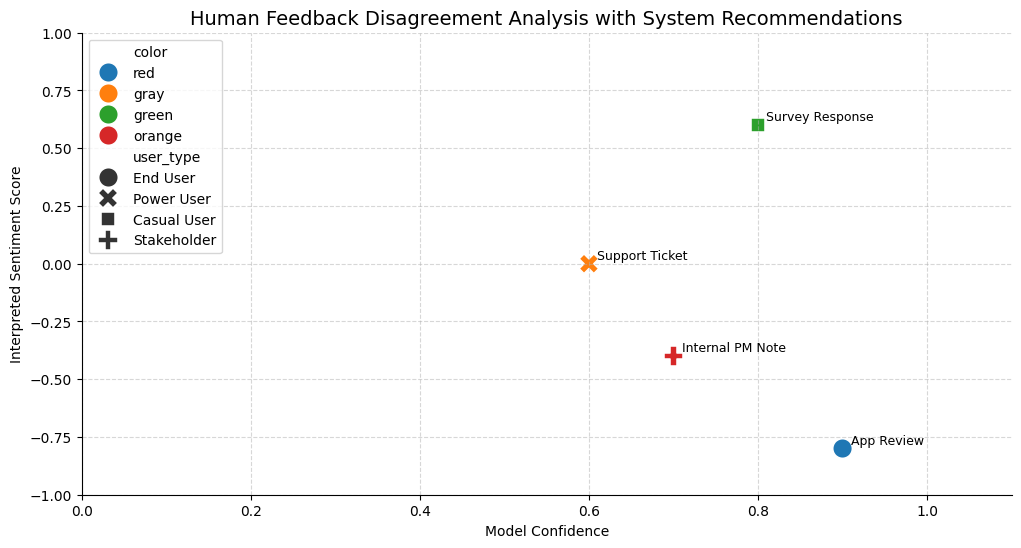

/tmp/ipython-input-731621840.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=metrics_df, palette="viridis")


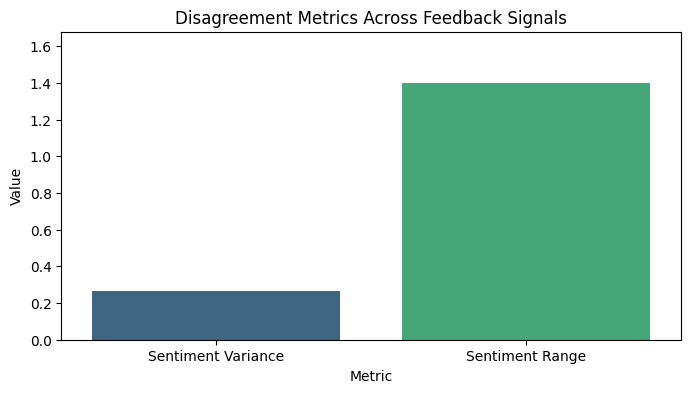

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame
df_feedback = pd.DataFrame(llm_feedback_analysis)

# Map urgency to numeric for plotting
urgency_map = {"Low": 0.3, "Medium": 0.6, "High": 0.9}
df_feedback["urgency_score"] = df_feedback["interpreted_urgency"].map(urgency_map)

# Map colors to sentiment
sentiment_colors = { -0.8: "red", -0.4: "orange", 0.0: "gray", 0.6: "green"}
df_feedback["color"] = df_feedback["interpreted_sentiment_score"].map(sentiment_colors)

plt.figure(figsize=(12,6))

# Scatter plot: sentiment vs model confidence
sns.scatterplot(
    data=df_feedback,
    x="model_confidence",
    y="interpreted_sentiment_score",
    hue="color",
    style="user_type",
    s=200
)

# Annotate each point with source
for i, row in df_feedback.iterrows():
    plt.text(
        row["model_confidence"] + 0.01,
        row["interpreted_sentiment_score"] + 0.02,
        row["source"],
        fontsize=9
    )

plt.title("Human Feedback Disagreement Analysis with System Recommendations", fontsize=14)
plt.xlabel("Model Confidence")
plt.ylabel("Interpreted Sentiment Score")
plt.xlim(0, 1.1)
plt.ylim(-1, 1)
plt.grid(True, linestyle="--", alpha=0.5)
sns.despine()
plt.show()

# Optional: visualize disagreement metrics as a bar
plt.figure(figsize=(8,4))
metrics_df = pd.DataFrame({
    "Metric": ["Sentiment Variance", "Sentiment Range"],
    "Value": [disagreement_metrics["sentiment_variance"], disagreement_metrics["sentiment_range"]]
})
sns.barplot(x="Metric", y="Value", data=metrics_df, palette="viridis")
plt.title("Disagreement Metrics Across Feedback Signals")
plt.ylim(0, max(metrics_df["Value"])*1.2)
plt.show()

## Step 8 — Summary & Engineering Takeaways

This final step consolidates insights from the human feedback disagreement framework and emphasizes **responsible decision-making under uncertainty**.

Goals:
- Recap system behavior under conflicting human signals
- Highlight engineering design choices for abstention, deferral, and escalation
- Provide guidance for operational deployment and portfolio presentation

### What This Step Does

- Summarizes key metrics, such as:
  - Number of feedback signals
  - Detected polarization
  - Confidence collapse occurrences
  - Recommended actions (Proceed, Defer, Abstain, Escalate)
- Reinforces **human-in-the-loop** as a core component
- Emphasizes safe, auditable decision-making under disagreement
- Highlights how structured analysis and visualization make subjective inputs actionable

In [8]:
# Summarize system outcomes
total_feedback = len(human_feedback)
actions_count = {
    "Proceed with Caution": 0,
    "Defer Decision": 0,
    "Abstain": 0,
    "Escalate to Human Review": 0
}

action = system_recommendation["recommended_action"]
actions_count[action] += 1

summary_metrics = {
    "Total Feedback Signals": total_feedback,
    "Recommended Action": action,
    "Detected Polarization": disagreement_metrics["polarization_detected"],
    "Confidence Collapse": decision_risk_profile["confidence_collapse"]
}

summary_metrics

{'Total Feedback Signals': 4,
 'Recommended Action': 'Defer Decision',
 'Detected Polarization': np.True_,
 'Confidence Collapse': np.False_}